In [1]:
import os 
import sys

import numpy as np
import matplotlib.pyplot as plt

from astropy.io import fits
from astropy.table import Table
import pandas as pd
import scipy.signal as signal

sys.path.append("/home/jovyan/experience-analysis-of-grb-emission-mmlab02")

In [2]:
#vediamo quali detector hanno avuto un segnale di trigger
detected=[]
main_dir =os.getcwd()

data_dir = os.path.join(main_dir,"data/current")
TTE_dir=os.path.join(data_dir,'spectral_stuff_with_XSPEC/files_TTE')

file_tcat = 'glg_trigdat_all_bn090926181_v01.fit'
input_filename_tcat = os.path.join(data_dir, file_tcat)
fits_info_tcat = fits.open(input_filename_tcat)
print('Trig data file')
fits_info_tcat.info() # there is 1 HDU

header_tcat = fits_info_tcat[0].header
print("Triggered NaI detectors %s" % header_tcat['DET_MASK'])

#vediamo quali sono gli HDU di un file
file='glg_tte_n3_bn090926181_v00.fit'
input_filename = os.path.join(TTE_dir,file)
fits_info= fits.open(input_filename)
print('\nTTE example file')
fits_info.info() #there are 4 HDUs 

header = fits_info[2].header
print('\n HDU 2 header')
print(f'Total number of channels in each rate = %s' % header["DETCHANS"])
header

Trig data file
Filename: /home/jovyan/experience-analysis-of-grb-emission-mmlab02/data/current/glg_trigdat_all_bn090926181_v01.fit
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      49   ()      
  1  TRIGRATE      1 BinTableHDU     48   1R x 5C   [1D, 1D, 4E, 3E, 112E]   
  2  BCKRATES      1 BinTableHDU     46   1R x 4C   [1D, 1D, 2B, 112E]   
  3  OB_CALC       1 BinTableHDU     74   2R x 15C   [1D, 1E, 1E, 1E, 1I, 2I, 2E, 1E, 1E, 1E, 1E, 12I, 1E, 1E, 1E]   
  4  MAXRATES      1 BinTableHDU     49   2R x 5C   [1D, 1D, 4E, 3E, 112E]   
  5  EVNTRATE      1 BinTableHDU     49   153R x 5C   [1D, 1D, 4E, 3E, 112E]   
Triggered NaI detectors 000100010000

TTE example file
Filename: /home/jovyan/experience-analysis-of-grb-emission-mmlab02/data/current/spectral_stuff_with_XSPEC/files_TTE/glg_tte_n3_bn090926181_v00.fit
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      36   ()      
  1  EBOUNDS 

XTENSION= 'BINTABLE'           / binary table extension                         
BITPIX  =                    8 / 8-bit bytes                                    
NAXIS   =                    2 / 2-dimensional binary table                     
NAXIS1  =                   10 / width of table in bytes                        
NAXIS2  =               436328 / number of rows in table                        
PCOUNT  =                    0 / size of special data area                      
GCOUNT  =                    1 / one data group (required keyword)              
TFIELDS =                    2 / number of fields in each row                   
TTYPE1  = 'TIME    '           / label for field   1                            
TFORM1  = '1D      '           / data format of field: 8-byte DOUBLE            
TUNIT1  = 's       '           / physical unit of field                         
TZERO1  =     275631628.986532 / Offset, equal to TRIGTIME                      
TTYPE2  = 'PHA     '        

## NAI DETECTORS

bg 251.310044 \pm 15.162005
This file 1 contains an event!
bg 269.807860 \pm 16.535069
This file 2 contains an event!
bg 264.408297 \pm 16.197111
This file 3 contains an event!
bg 243.301310 \pm 15.671743
This file 4 contains an event!
bg 191.148472 \pm 14.550612
This file 5 contains an event!
bg 231.144105 \pm 14.702916
This file 6 contains an event!
bg 226.844978 \pm 14.707779
This file 7 contains an event!
bg 250.849345 \pm 15.960828
This file 8 contains an event!
bg 222.762009 \pm 15.717557
This file 9 contains an event!
bg 262.967249 \pm 16.598029
This file 10 contains an event!
bg 276.914847 \pm 15.752014
This file 11 contains an event!
bg 238.652838 \pm 16.159535
This file 12 contains an event!


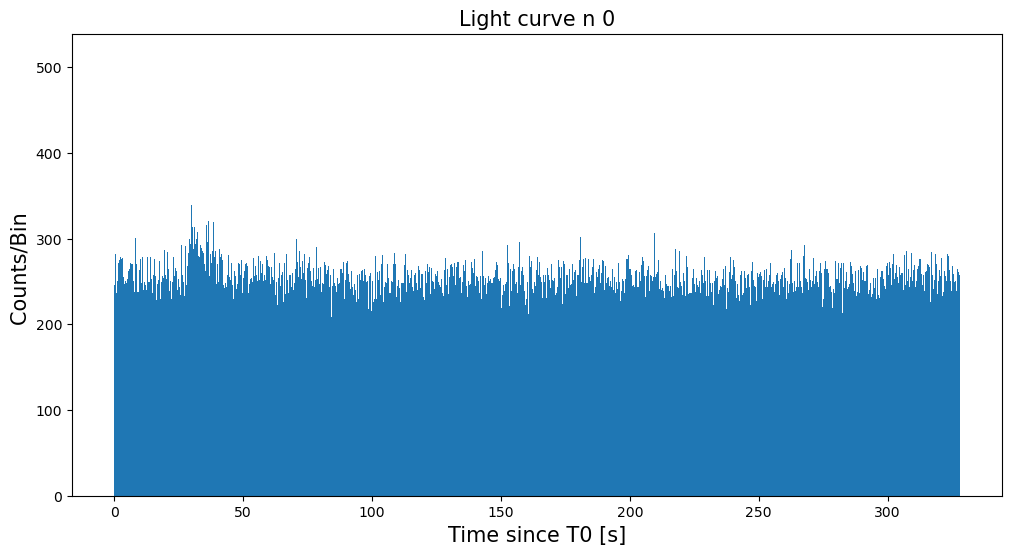

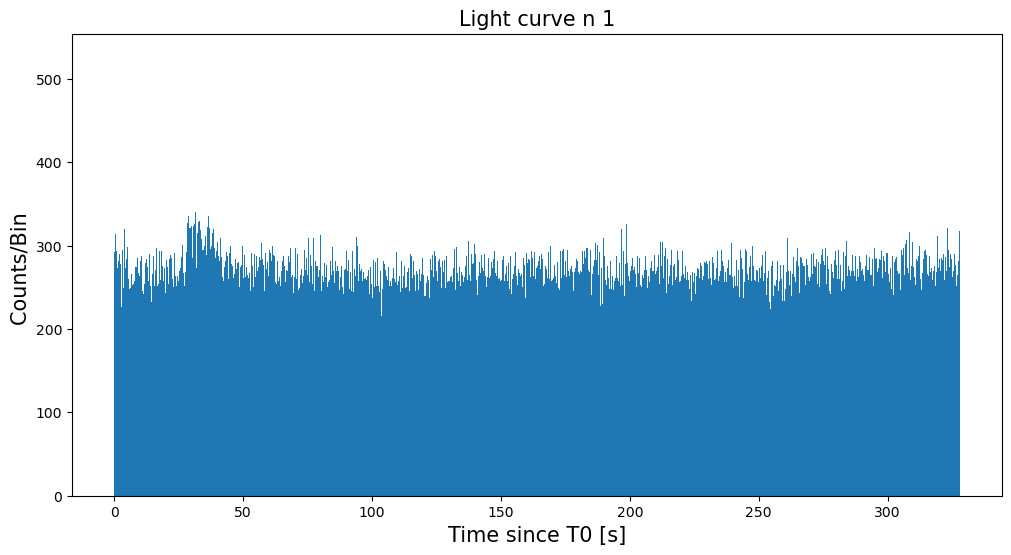

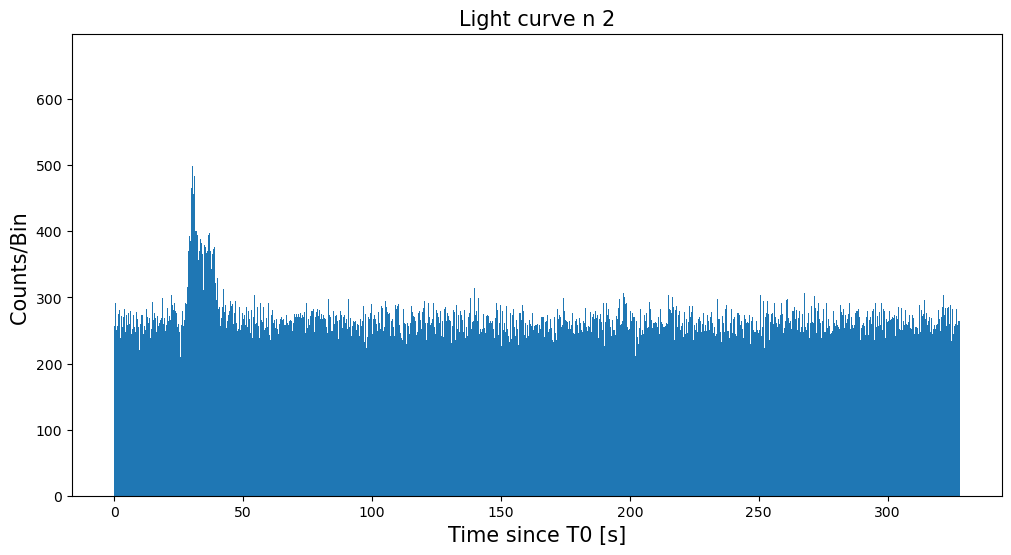

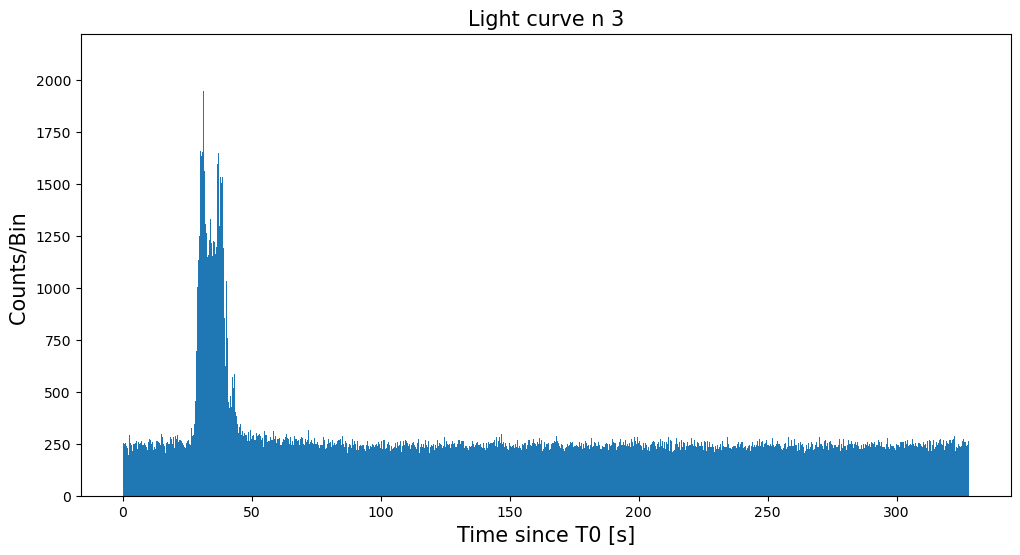

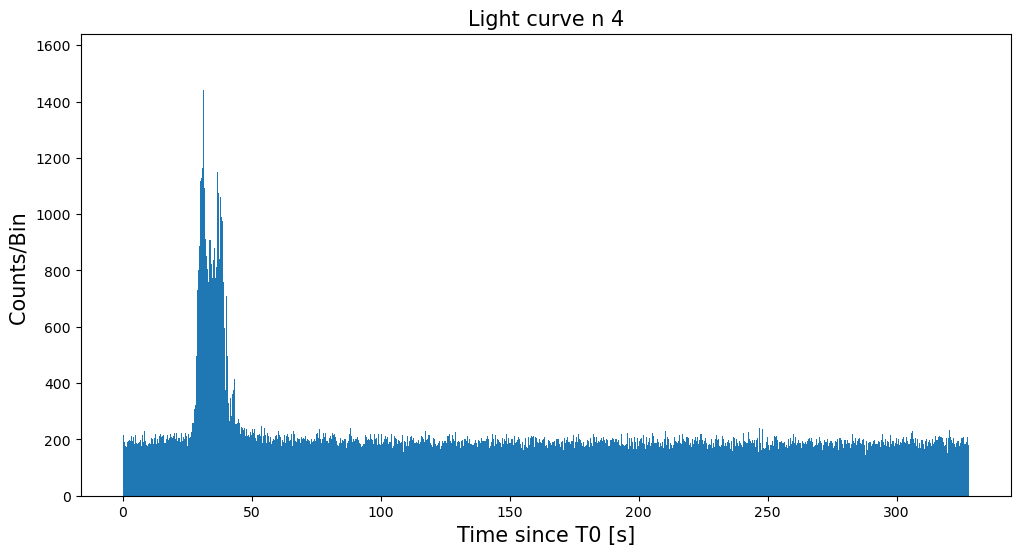

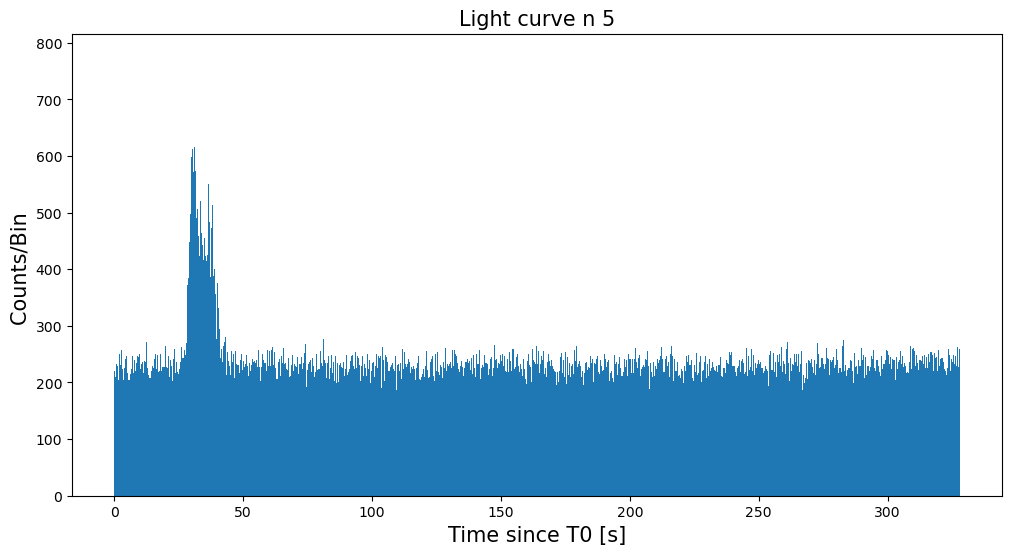

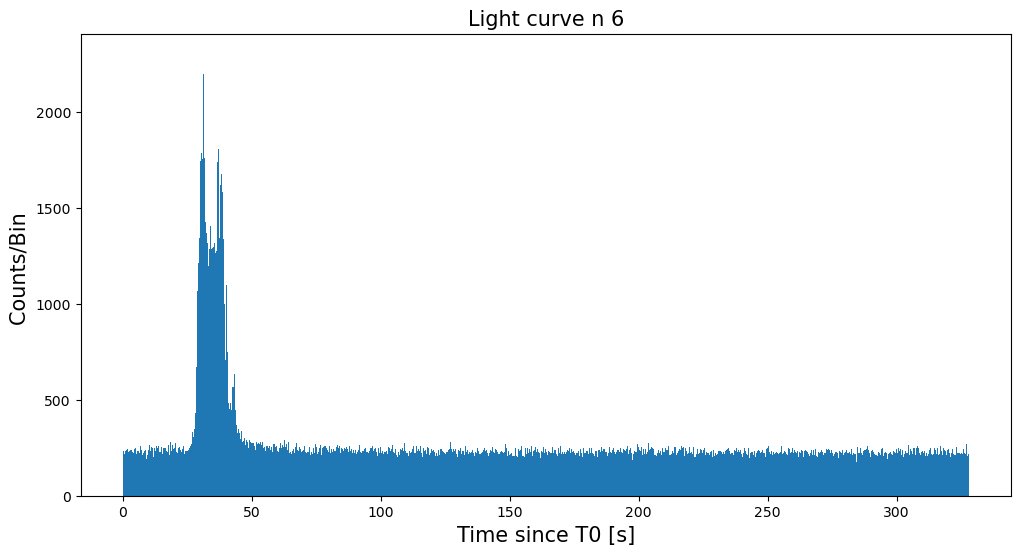

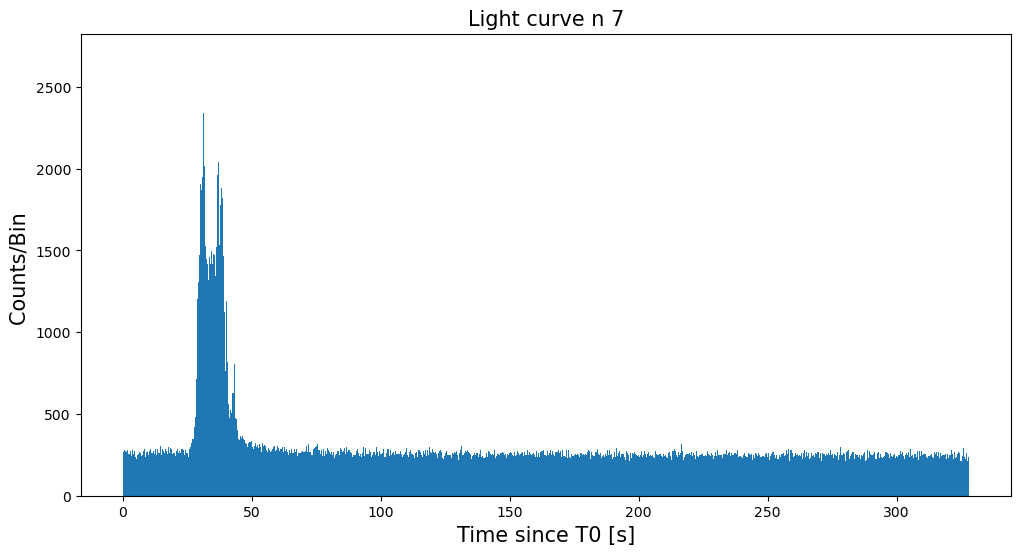

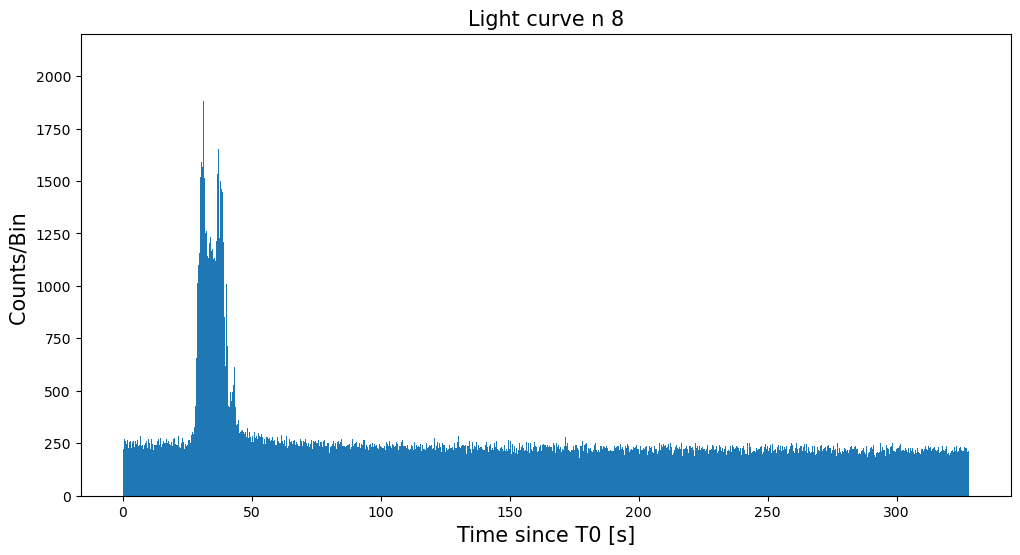

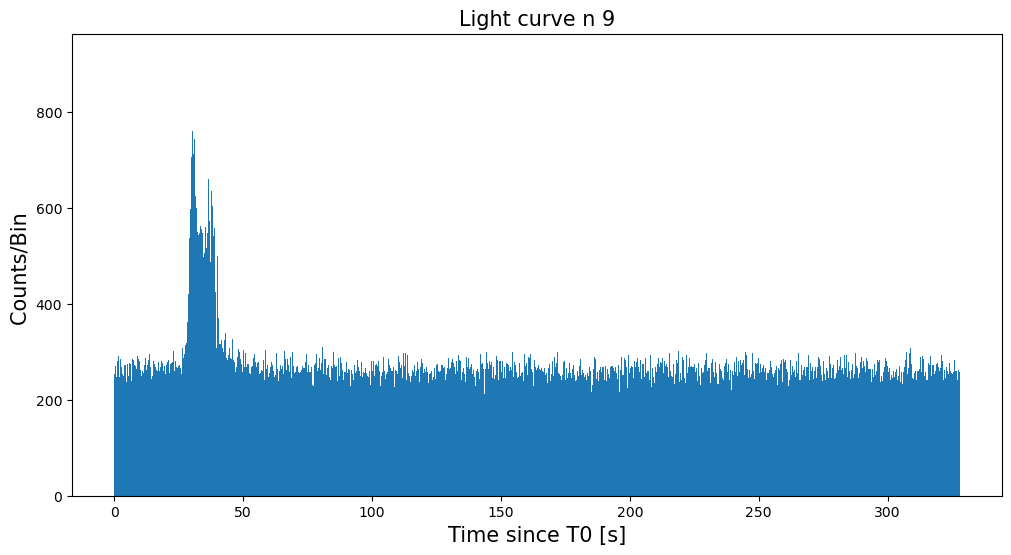

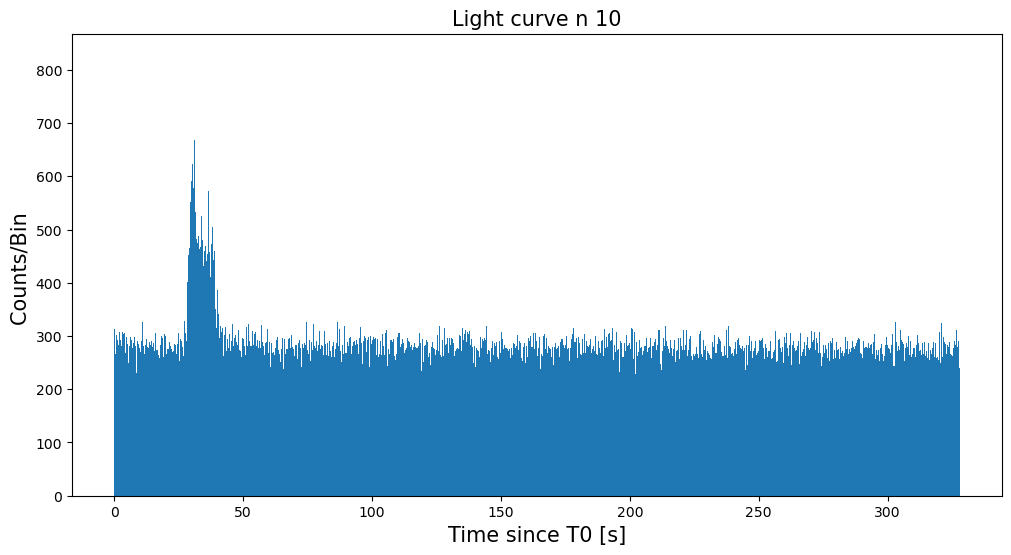

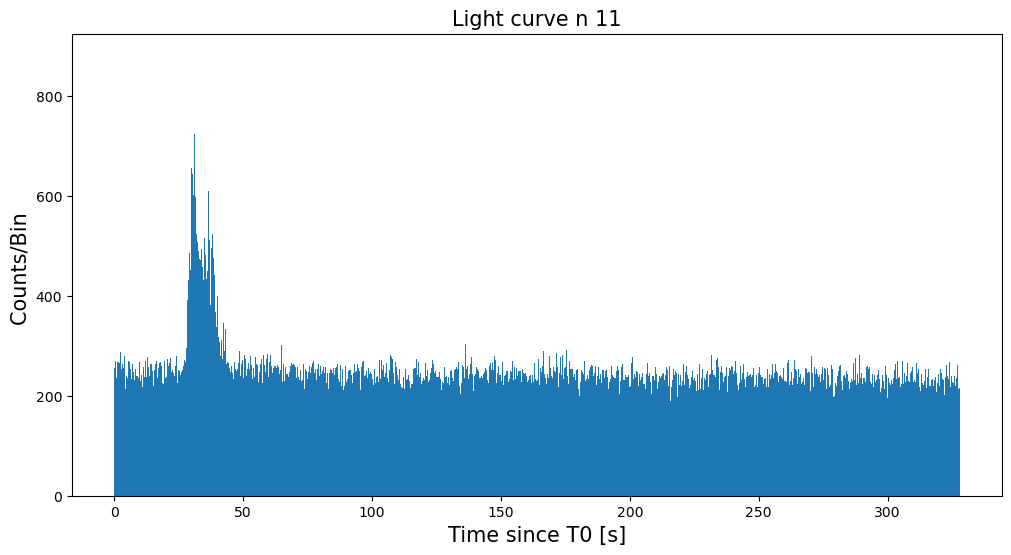

In [3]:
# file TTE contiene i dati dell'osservazione [time tagged event]
files = sorted(os.listdir(TTE_dir))
NAI_files=[]
for file in files:
    if "glg_tte_n" in file: #selecting NAI detectors
        NAI_files=np.append(NAI_files, file) 
        
acceptance=5 #-> 3 soft acceptance, 5 hard acceptance

ii=0
for file in NAI_files:
    input_filename = os.path.join(TTE_dir,file)
    fits_info = fits.open(input_filename) # opening header
    header = fits_info[2].header
    data=fits.getdata(input_filename, ext=2) # open file fits
    n = Table(data)
    dfn= n.to_pandas() # create pandas data frame
    t=dfn['TIME']
    dt= t- np.min(t) #time from start of observation

    #light curve
    plt.figure(figsize=(12,6))
    plt.title('Light curve n %d' %(ii), fontsize=15)
    plt.xlabel('Time since T0 [s]', fontsize=15)
    plt.ylabel('Counts/Bin ', fontsize=15)
    bin_heights, bin_counts,_=plt.hist(dt,bins=1500)
    plt.ylim([0,np.max(bin_heights)+200])
    ii+=1
    
    # selecting window for computing background
    window_beginning=200
    window_ending=300
    start = bin_counts>window_beginning 
    stop = bin_counts<window_ending
    mask_dt = np.logical_and(start, stop)

    bg=np.mean(bin_heights[mask_dt[:len(mask_dt)-1]]) #background
    err_bg=np.std(bin_heights[mask_dt[:len(mask_dt)-1]]) # background error
    print('bg %f \pm %f' %(bg,err_bg))

    mask_event=bin_heights>acceptance*err_bg+bg

    if len(bin_heights[mask_event])!=0:
        print('This file %d contains an event!' %(ii))
        detected=np.append(detected,file)
    else:
        print('This file %d does NOT contain an event:' %(ii))

Nonostante solo il 3 e 7 detector diano il trigger per il segnale, tutti quanti osservano il burst, perche' la dev. stand. del background e' sufficientemente bassa da registrare un segnale in ogni NaI detector.

Gli NaI che hanno visualizzato per primi sono quelli che erano orientati meglio e che hanno piu' conteggi.

## BGO detectors

bg 617.371179 \pm 25.687104
This file 1 contains an event!
bg 520.076419 \pm 24.001925
This file 2 contains an event!


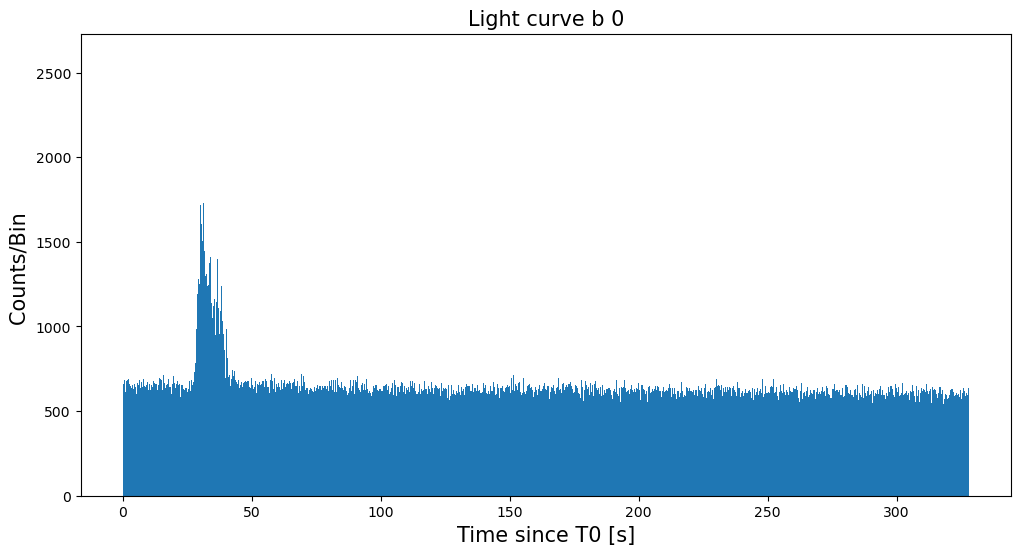

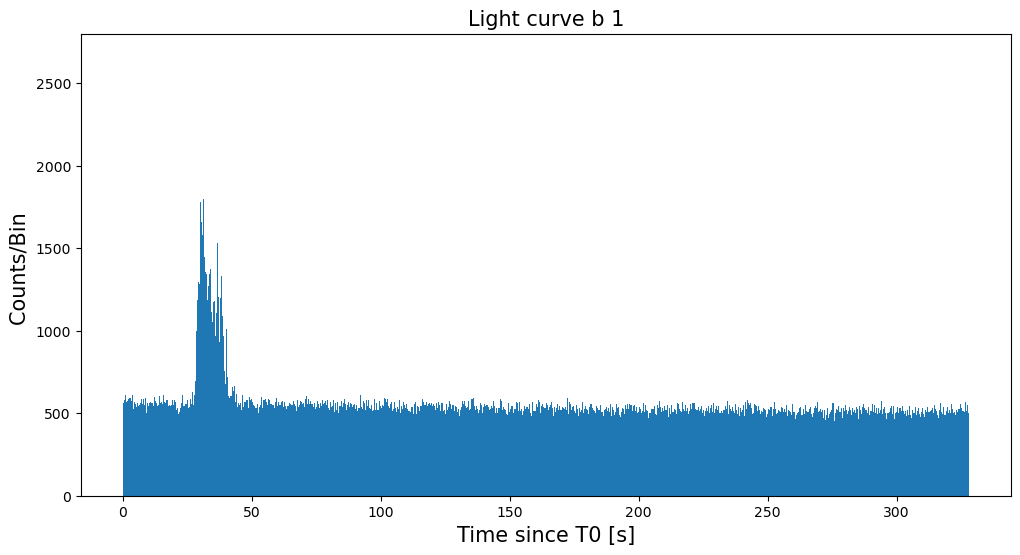

In [4]:
#apriamo i TTE files
BG0_files=[]
for file in files:
    if "glg_tte_b" in file: #selecting BGO detectors
        BG0_files=np.append(BG0_files, file) 

ii=0
for file in BG0_files:
    input_filename = os.path.join(TTE_dir,file)
    data=fits.getdata(input_filename, ext=2)
    n = Table(data)
    dfn= n.to_pandas()
    
    t=dfn['TIME']
    dt= t- np.min(t) #time from start of observation
    
    #light curve
    plt.figure(figsize=(12,6))
    plt.title('Light curve b %d' %(ii), fontsize=15)
    plt.xlabel('Time since T0 [s]', fontsize=15)
    plt.ylabel('Counts/Bin ', fontsize=15)
    bin_heights, bin_counts,_=plt.hist(dt,bins=1500)
    plt.ylim([0,np.max(bin_heights)+1000])
    ii+=1
    
    window_beginning=200
    window_ending=300
    start = bin_counts>window_beginning 
    stop = bin_counts<window_ending
    mask_dt = np.logical_and(start, stop)

    bg=np.mean(bin_heights[mask_dt[:len(mask_dt)-1]]) #background
    err_bg=np.std(bin_heights[mask_dt[:len(mask_dt)-1]])
    print('bg %f \pm %f' %(bg,err_bg))

    mask_event=bin_heights>acceptance*err_bg+bg

    if len(bin_heights[mask_event])!=0:
        print('This file %d contains an event!' %(ii))
        detected=np.append(detected,file)
    else:
        print('This file %d does NOT contain an event:' %(ii))

(0.0, 18217.0)

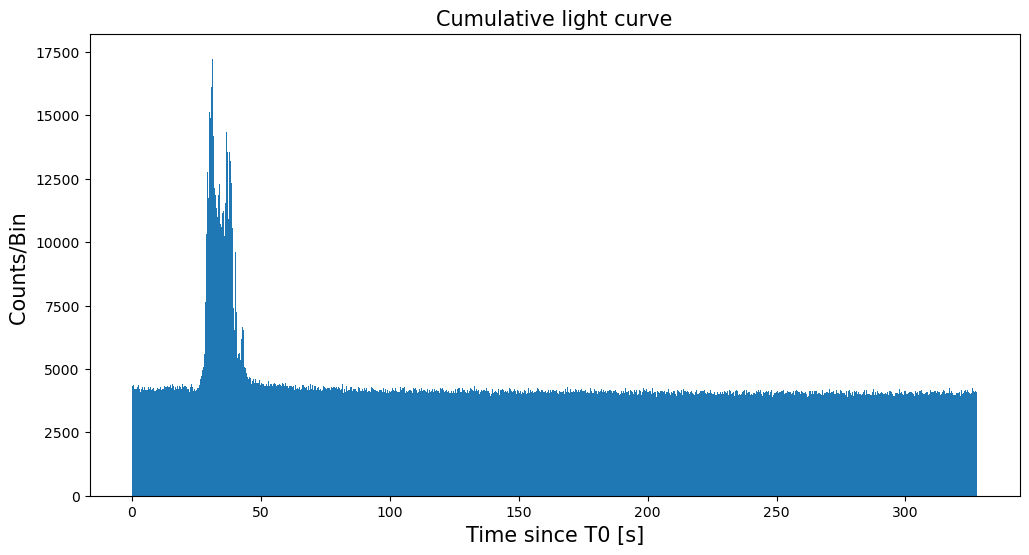

In [5]:
pat=[] #photon arrival time 
for file in detected:
    input_filename = os.path.join(TTE_dir,file)
    data=fits.getdata(input_filename, ext=2)
    n = Table(data)
    dfn= n.to_pandas()
    
    t=dfn['TIME']
    dt= t- np.min(t) #time from start of observation
    pat=np.append(pat,dt)

#light curve
plt.figure(figsize=(12,6))
plt.title('Cumulative light curve', fontsize=15)
plt.xlabel('Time since T0 [s]', fontsize=15)
plt.ylabel('Counts/Bin ', fontsize=15)

hist, bins=np.histogram(pat,bins=1500)
plt.hist(pat,bins=bins)
plt.ylim([0,np.max(hist)+1000])

bg 4067.578603 \pm 70.197657


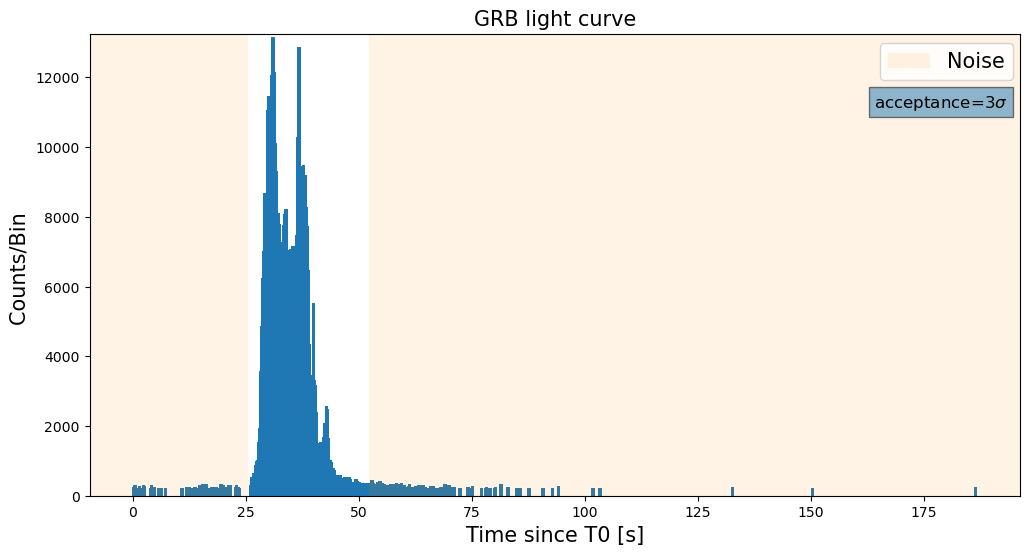

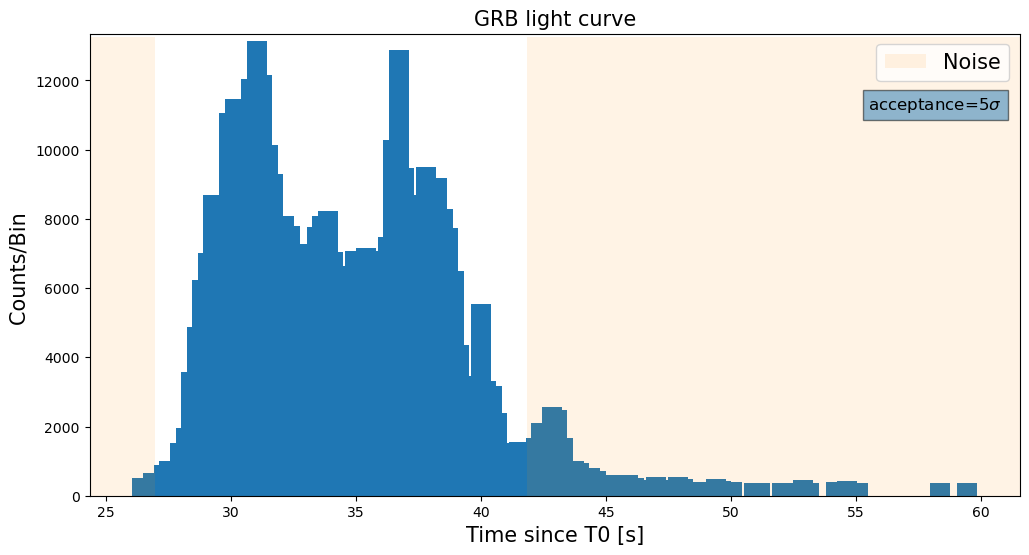

In [6]:
window_beginning=200
window_ending=300
start = bins>window_beginning 
stop = bins<window_ending
mask_dt = np.logical_and(start, stop)

bg=np.mean(hist[mask_dt[:len(mask_dt)-1]]) #background dell'istogramma cumulativo
err_bg=np.std(hist[mask_dt[:len(mask_dt)-1]])
print('bg %f \pm %f' %(bg,err_bg))

#light curve  (soft acceptance)
adj_hist=hist-bg
mask_event=hist>3*err_bg+bg

plt.figure(figsize=(12,6))
plt.bar(bins[:-1][mask_event],adj_hist[mask_event])
plt.title('GRB light curve', fontsize=15)
plt.xlabel('Time since T0 [s]', fontsize=15)
plt.ylabel('Counts/Bin ', fontsize=15)

plt.axhspan(0, np.max(adj_hist[mask_event])+100, 0, 0.17, facecolor='darkorange', alpha=0.1, label='Noise')
plt.axhspan(0, np.max(adj_hist[mask_event])+100, 0.3, 1, facecolor='darkorange', alpha=0.1)
plt.text(164, np.max(adj_hist[mask_event])-2000,'acceptance=3$\sigma$', fontsize=12,bbox=dict(alpha=0.5))
plt.legend(loc=(0.85,0.9), fontsize=15)
plt.ylim([0,np.max(adj_hist[mask_event])+100])

#light curve (hard acceptance)
adj_hist=hist-bg
mask_event=hist>acceptance*err_bg+bg

plt.figure(figsize=(12,6))
plt.bar(bins[:-1][mask_event],adj_hist[mask_event])
plt.title('GRB light curve', fontsize=15)
plt.xlabel('Time since T0 [s]', fontsize=15)
plt.ylabel('Counts/Bin ', fontsize=15)
plt.ylim([0,np.max(adj_hist[mask_event])+200])
plt.axhspan(0, np.max(adj_hist[mask_event])+100, 0, 0.07, facecolor='darkorange', alpha=0.1, label='Noise')
plt.axhspan(0, np.max(adj_hist[mask_event])+100, 0.47, 1, facecolor='darkorange', alpha=0.1)
plt.text(55.5, np.max(adj_hist[mask_event])-2000,'acceptance=5$\sigma$', fontsize=12,bbox=dict(alpha=0.5))
plt.legend(loc='best', fontsize=15)

### Computing T90

In [7]:
# the background has been subtracted from the cumulative histogram, che T90 can be computes as the time interval 
# between 5% of the total number of photons and the 95% (above noise which is absent in our plot)

times = bins[:-1][mask_event]
mask_phot= adj_hist[mask_event]
photons_tot = np.sum(mask_phot) 
print('total counts above background = %f' % photons_tot)
start_count=photons_tot*5/100
stop_count=photons_tot*95/100
print('five percent of counts = %f' %start_count)
print('ninety five percent of counts = %f' %stop_count)

dt = max(bins)/1500
print('Bin width = %f' % dt)

# cerco di trovare il punto dove ho il 5% di conteggi
for ii in range(len(mask_phot)):
    somma=np.sum(mask_phot[:ii])
    cond1=somma<start_count+1000
    cond2=somma>start_count-1000
    cond=np.logical_and(cond1,cond2)
    if cond==True:
        print('Found start')
        print(somma)
        print('array index= %d' %ii)
        start_time = times[ii]
        print('start time= %f' % start_time)
        print('start counts = %f' % mask_phot[ii])
        start_error = np.sqrt(mask_phot[ii])
        print('start counts error = %f' % start_error)

        err_start = abs(start_count - somma) / photons_tot * max(times) 

# cerco di trovare il punto dove ho il 95% di conteggi
for jj in range(len(mask_phot)):
    somma=np.sum(mask_phot[:jj])
    cond1=somma<stop_count+500
    cond2=somma>stop_count-500
    cond=np.logical_and(cond1,cond2)
    if cond==True:
        print('Found stop')
        print(somma)
        print('array index= %d' %ii)
        stop_time = times[jj]
        print('stop time= %f' % stop_time)
        print('stop counts = %f' % mask_phot[jj])
        stop_error = np.sqrt(mask_phot[jj])
        print('stop counts error = %f' % stop_error)
        
        err_stop = abs(stop_count - somma) / photons_tot * max(times)

# errore massimo
print('start time error = %f ' % err_start)
print('stop time error = %f ' % err_stop)

err_tot_start = np.sqrt(err_start**2 + dt**2)
err_tot_stop = np.sqrt(err_stop**2 + dt**2)
print('err_tot_start = %f' % err_tot_start)
print('err_tot_stop = %f' % err_tot_stop)
        
# errore """"statistico""""
err_start = start_error / photons_tot * max(times) 
err_stop = stop_error / photons_tot * max(times)
print('start time error = %f ' % err_start)
print('stop time error = %f ' % err_stop)

t_90 = stop_time - start_time
print('T90 is %.2f +/- %.2f s' % (t_90, np.sqrt(2)*dt)) # long grb 

total counts above background = 479611.882096
five percent of counts = 23980.594105
ninety five percent of counts = 455631.287991
Bin width = 0.218601
Found start
23186.056768558952
array index= 12
start time= 29.073948
start counts = 7013.421397
start counts error = 83.746172
Found stop
455855.02620087325
array index= 115
stop time= 43.064419
stop counts = 2475.421397
stop counts error = 49.753607
start time error = 0.098502 
stop time error = 0.027738 
err_tot_start = 0.239769
err_tot_stop = 0.220354
start time error = 0.010382 
stop time error = 0.006168 
T90 is 13.99 +/- 0.31 s


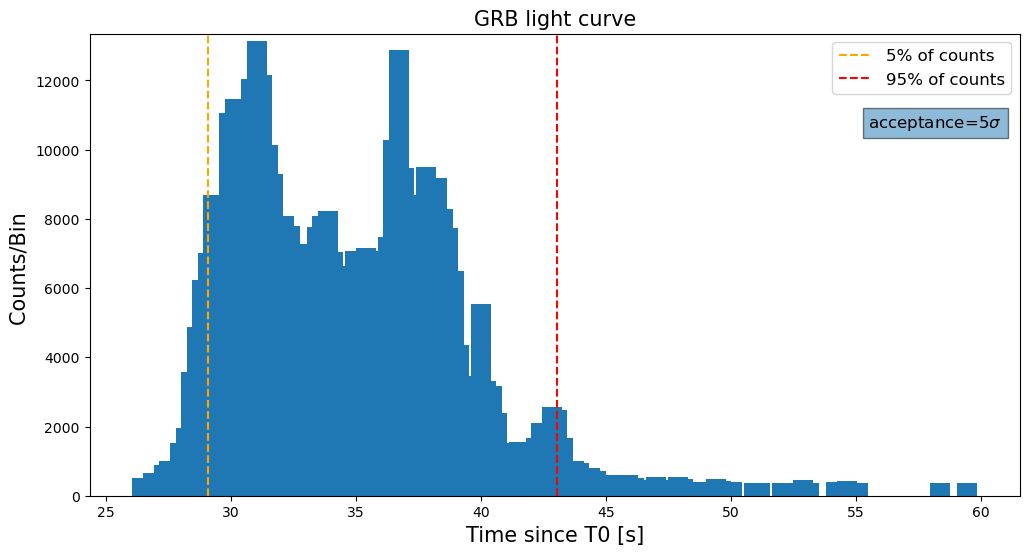

In [8]:
#light curve (hard acceptance) with T90
adj_hist=hist-bg
mask_event=hist>acceptance*err_bg+bg

plt.figure(figsize=(12,6))
plt.bar(bins[:-1][mask_event],adj_hist[mask_event])
plt.title('GRB light curve', fontsize=15)
plt.xlabel('Time since T0 [s]', fontsize=15)
plt.ylabel('Counts/Bin ', fontsize=15)
plt.ylim([0,np.max(adj_hist[mask_event])+200])
#plt.axhspan(0, np.max(adj_hist[mask_event])+100, 0, 0.07, facecolor='darkorange', alpha=0.1, label='Noise')
#plt.axhspan(0, np.max(adj_hist[mask_event])+100, 0.52, 1, facecolor='darkorange', alpha=0.1)
plt.text(55.5, np.max(adj_hist[mask_event])-2500,'acceptance=5$\sigma$', fontsize=12,bbox=dict(alpha=0.5))
plt.axvline(x=start_time, linestyle='dashed', color='orange', label='5% of counts')
plt.axvline(x=stop_time, linestyle='dashed', color='red', label='95% of counts')
plt.legend(loc='best', fontsize=12)

### Light curves for energy bands

In [9]:
file='glg_tte_n3_bn090926181_v00.fit'
input_filename = os.path.join(TTE_dir,file)
fits_info= fits.open(input_filename)
fits_info.info() #there are 4 HDUs 

header = fits_info[1].header # le energie sono espresse in kev
header
data_en = fits.getdata(input_filename, ext=1) 
energy_bounds = Table(data_en)
df = energy_bounds.to_pandas()
channel = df['CHANNEL']
e_min = df['E_MIN']
e_max = df['E_MAX']

# for NaI 15-260 KeV & 10-15
cond1=e_min>15
cond2=e_max<260
mask = cond1 & cond2
wanted_channels=channel[mask]
df

Filename: /home/jovyan/experience-analysis-of-grb-emission-mmlab02/data/current/spectral_stuff_with_XSPEC/files_TTE/glg_tte_n3_bn090926181_v00.fit
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      36   ()      
  1  EBOUNDS       1 BinTableHDU     58   128R x 3C   [1I, 1E, 1E]   
  2  EVENTS        1 BinTableHDU     48   436328R x 2C   [1D, 1I]   
  3  GTI           1 BinTableHDU     44   1R x 2C   [1D, 1D]   


,CHANNEL,E_MIN,E_MAX
0,0,4.233729,5.174686
1,1,5.174686,6.090552
2,2,6.090552,6.985920
3,3,6.985920,7.865383
4,4,7.865383,8.733535
...,...,...,...
123,123,860.982300,884.514343
124,124,884.514343,908.541748
125,125,908.541748,944.790894
126,126,944.790894,982.231873


,TIME,PHA
0,2.756316e+08,34
1,2.756316e+08,14
2,2.756316e+08,11
3,2.756316e+08,34
4,2.756316e+08,30
...,...,...
436323,2.756319e+08,127
436324,2.756319e+08,14
436325,2.756319e+08,12
436326,2.756319e+08,31


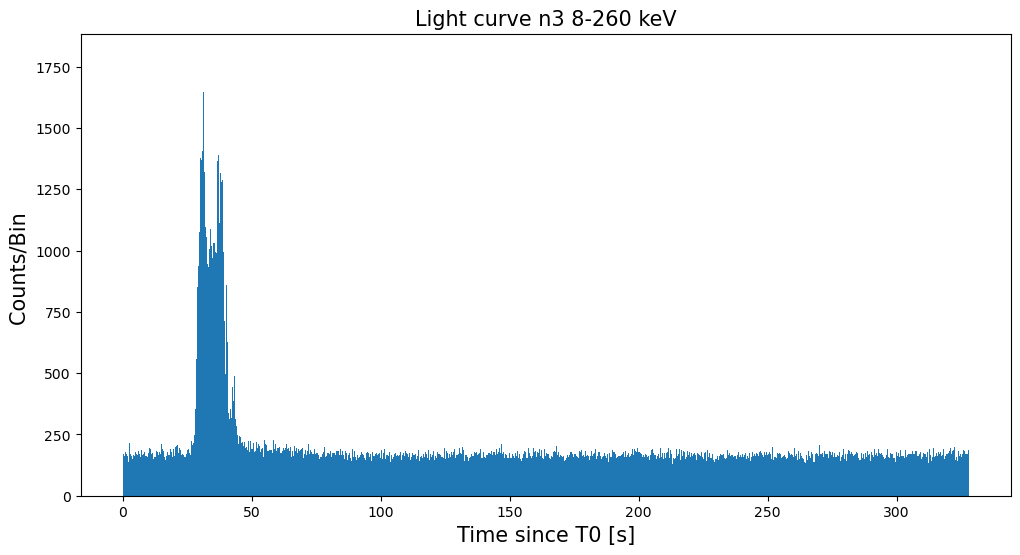

In [10]:
data_counts = fits.getdata(input_filename, ext=2) 
counts = Table(data_counts)
df_c = counts.to_pandas()
pha = df_c['PHA']
time = df_c['TIME']

mask_pha = pha.isin(wanted_channels)
selected_time = time[mask_pha]

dt= selected_time.array- np.min(selected_time.array) #time from start of observation

#light curve
plt.figure(figsize=(12,6))
plt.title('Light curve n3 8-260 keV', fontsize=15)
plt.xlabel('Time since T0 [s]', fontsize=15)
plt.ylabel('Counts/Bin ', fontsize=15)
bin_heights, bin_counts,_=plt.hist(dt,bins=1500)
plt.ylim([0,np.max(bin_heights)+200])

df_c


bg 165.174672 \pm 13.046610


Text(46, 1449.825327510917, 'acceptance=5$\\sigma$')

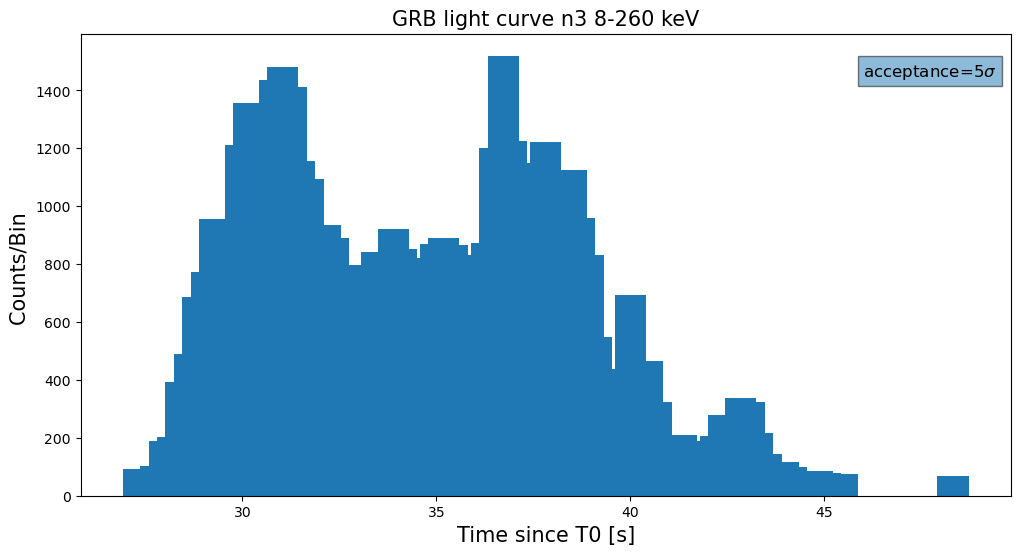

In [11]:
    # selecting window for computing background
window_beginning=200
window_ending=300
start = bin_counts>window_beginning 
stop = bin_counts<window_ending
acceptance = 5

mask_dt = np.logical_and(start, stop)
bg=np.mean(bin_heights[mask_dt[:len(mask_dt)-1]]) #background
err_bg=np.std(bin_heights[mask_dt[:len(mask_dt)-1]]) # background error
print('bg %f \pm %f' %(bg,err_bg))

mask_event=bin_heights>acceptance*err_bg+bg
adj_hist=bin_heights-bg

plt.figure(figsize=(12,6))
plt.bar(bin_counts[:-1][mask_event],adj_hist[mask_event])
plt.title('GRB light curve n3 8-260 keV', fontsize=15)
plt.xlabel('Time since T0 [s]', fontsize=15)
plt.ylabel('Counts/Bin ', fontsize=15)
plt.text(46, np.max(adj_hist[mask_event])-70,'acceptance=5$\sigma$', fontsize=12,bbox=dict(alpha=0.5))


### Individuazione picchi curva di luce

Filename: /home/jovyan/experience-analysis-of-grb-emission-mmlab02/data/current/spectral_stuff_with_XSPEC/files_TTE/glg_tte_b0_bn090926181_v00.fit
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      36   ()      
  1  EBOUNDS       1 BinTableHDU     58   128R x 3C   [1I, 1E, 1E]   
  2  EVENTS        1 BinTableHDU     48   977520R x 2C   [1D, 1I]   
  3  GTI           1 BinTableHDU     44   1R x 2C   [1D, 1D]   
Times of selected peaks [30.05763933 31.1506444  35.52266467 36.83427075 37.92727581 40.11328595]


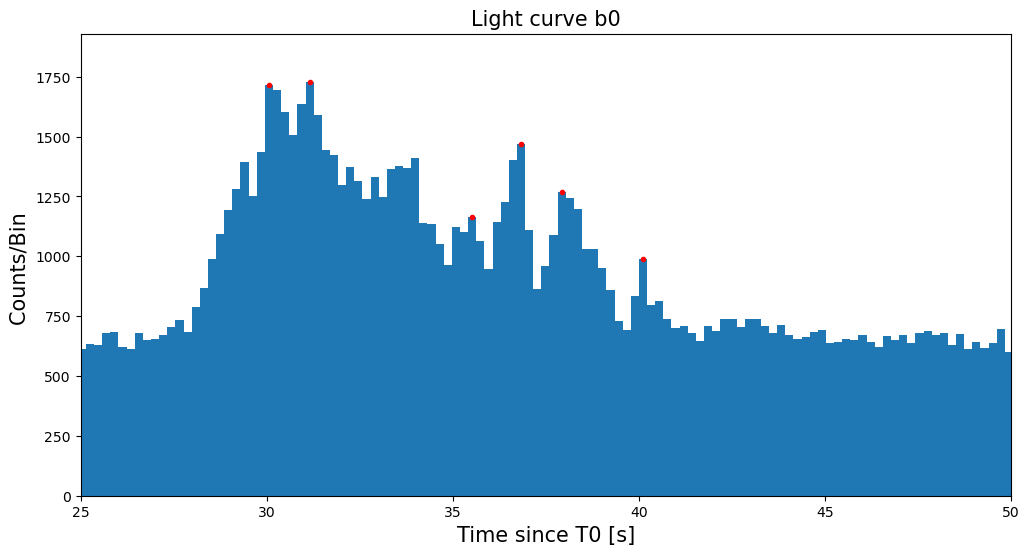

In [12]:
file='glg_tte_b0_bn090926181_v00.fit'
input_filename = os.path.join(TTE_dir,file)
fits_info= fits.open(input_filename)
fits_info.info() #there are 4 HDUs 

data_counts = fits.getdata(input_filename, ext=2) 
counts = Table(data_counts)
df_c = counts.to_pandas()
time = df_c['TIME']

dt = time - np.min(time)
plot=plt.figure(figsize=(12,6))
plt.title('Light curve b0', fontsize=15)
plt.xlabel('Time since T0 [s]', fontsize=15)
plt.ylabel('Counts/Bin ', fontsize=15)
bin_heights, bin_counts,_=plt.hist(dt,bins=1500)
plt.ylim([0,np.max(bin_heights)+200])
plt.xlim([25, 50])
ax = plot.gca()

# get bin centers

bin_width = (np.max(bin_counts)-np.min(bin_counts))/1500
bin_centers = bin_counts + bin_width/2
bin_centers = bin_centers[:-1] # tolgo l'ultimo perchè è l'estremo finale
peaks,_ = signal.find_peaks(bin_heights, prominence=200) # individuo i picchi
#err = [1, 1, 0.5, 0.5, 0.5, 0.5, 0.5]
plt.errorbar(bin_centers[peaks], bin_heights[peaks], fmt='.', color='red')
print('Times of selected peaks', bin_centers[peaks])


In [13]:
data_counts = fits.getdata(input_filename, ext=2) 
counts = Table(data_counts)
df_c = counts.to_pandas()
pha = df_c['PHA']
time = df_c['TIME']

mask_pha = pha.isin(wanted_channels)
selected_time = time[mask_pha]

dt= selected_time.array- np.min(selected_time.array) #time from start of observation

"""
#light curve
plt.figure(figsize=(12,6))
plt.title('Light curve n3 8-260 keV', fontsize=15)
plt.xlabel('Time since T0 [s]', fontsize=15)
plt.ylabel('Counts/Bin ', fontsize=15)
bin_heights, bin_counts,_=plt.hist(dt,bins=1500)
plt.ylim([0,np.max(bin_heights)+200])
"""
print(df_c)

                TIME  PHA
0       2.756316e+08    1
1       2.756316e+08   55
2       2.756316e+08   56
3       2.756316e+08   15
4       2.756316e+08    0
...              ...  ...
977515  2.756319e+08   35
977516  2.756319e+08    1
977517  2.756319e+08   10
977518  2.756319e+08   33
977519  2.756319e+08    7

[977520 rows x 2 columns]


In [14]:
file='glg_tte_n3_bn090926181_v00.fit'
input_filename = os.path.join(TTE_dir,file)
fits_info= fits.open(input_filename)
fits_info.info() #there are 4 HDUs 

header = fits_info[1].header # le energie sono espresse in kev
header
data_en = fits.getdata(input_filename, ext=1) 
energy_bounds = Table(data_en)
df = energy_bounds.to_pandas()
channel = df['CHANNEL']
e_min = df['E_MIN']
e_max = df['E_MAX']

# for NaI 10-15 KeV 
cond1=e_min>15
cond2=e_max<260
mask = cond1 & cond2
wanted_channels1=channel[mask]
print(wanted_channels1)

# for NaI 15-260 KeV
cond1=e_min>10
cond2=e_max<15
mask = cond1 & cond2
wanted_channels2=channel[mask]
print(wanted_channels2)

# for BGO 260 kev - 10 MeV
cond1=e_min>260
cond2=e_max<10000
mask = cond1 & cond2
wanted_channels3=channel[mask]
print(wanted_channels3)

Filename: /home/jovyan/experience-analysis-of-grb-emission-mmlab02/data/current/spectral_stuff_with_XSPEC/files_TTE/glg_tte_n3_bn090926181_v00.fit
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      36   ()      
  1  EBOUNDS       1 BinTableHDU     58   128R x 3C   [1I, 1E, 1E]   
  2  EVENTS        1 BinTableHDU     48   436328R x 2C   [1D, 1I]   
  3  GTI           1 BinTableHDU     44   1R x 2C   [1D, 1D]   
12    12
13    13
14    14
15    15
16    16
      ..
75    75
76    76
77    77
78    78
79    79
Name: CHANNEL, Length: 68, dtype: int16
7      7
8      8
9      9
10    10
Name: CHANNEL, dtype: int16
81      81
82      82
83      83
84      84
85      85
86      86
87      87
88      88
89      89
90      90
91      91
92      92
93      93
94      94
95      95
96      96
97      97
98      98
99      99
100    100
101    101
102    102
103    103
104    104
105    105
106    106
107    107
108    108
109    109
110    110
111 

In [15]:
data_counts = fits.getdata(input_filename, ext=2) 
counts = Table(data_counts)
df = counts.to_pandas()


dt_1 = df.loc[(df['PHA'] > 6) & (df['PHA'] < 11)]['TIME']
print(np.min(dt_1))
int_1 = dt_1 - np.min(dt_1)
int_1

275631602.077388


12          0.000000
15          0.002520
21          0.004252
58          0.044646
67          0.050278
             ...    
436199    327.775016
436217    327.795314
436243    327.812300
436265    327.834214
436280    327.849450
Name: TIME, Length: 30121, dtype: float64

In [16]:
data_counts = fits.getdata(input_filename, ext=2) 
counts = Table(data_counts)
df = counts.to_pandas()
pha = df['PHA']
time = df['TIME']

dt_2 = df.loc[(df['PHA'] > 11) & (df['PHA'] < 80)]['TIME']
int_2 = dt_2 - np.min(dt_2)
int_2


0           0.000000
1           0.000688
3           0.000976
4           0.001932
5           0.002114
             ...    
436322    327.899066
436324    327.899558
436325    327.899574
436326    327.900468
436327    327.901374
Name: TIME, Length: 309870, dtype: float64

In [17]:
file='glg_tte_b0_bn090926181_v00.fit'
input_filename = os.path.join(TTE_dir,file)


fits_info= fits.open(input_filename)
fits_info.info() #there are 4 HDUs 

header = fits_info[1].header # le energie sono espresse in kev
header
data_en = fits.getdata(input_filename, ext=1) 
energy_bounds = Table(data_en)
df = energy_bounds.to_pandas()
channel = df['CHANNEL']
e_min = df['E_MIN']
e_max = df['E_MAX']

cond1=e_min>260
cond2=e_max<10000
mask = cond1 & cond2
wanted_channels3=channel[mask]
print(wanted_channels3)


data_counts = fits.getdata(input_filename, ext=2) 
counts = Table(data_counts)
df = counts.to_pandas()

dt_3 = df.loc[(df['PHA'] > 2) & (df['PHA'] < 90)]['TIME']
int_3 = dt_3 - np.min(dt_3)
int_3


Filename: /home/jovyan/experience-analysis-of-grb-emission-mmlab02/data/current/spectral_stuff_with_XSPEC/files_TTE/glg_tte_b0_bn090926181_v00.fit
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      36   ()      
  1  EBOUNDS       1 BinTableHDU     58   128R x 3C   [1I, 1E, 1E]   
  2  EVENTS        1 BinTableHDU     48   977520R x 2C   [1D, 1I]   
  3  GTI           1 BinTableHDU     44   1R x 2C   [1D, 1D]   
3      3
4      4
5      5
6      6
7      7
      ..
85    85
86    86
87    87
88    88
89    89
Name: CHANNEL, Length: 87, dtype: int16


1           0.000000
2           0.000020
3           0.000034
6           0.001058
7           0.001146
             ...    
977514    327.899734
977515    327.899970
977517    327.900124
977518    327.900152
977519    327.900962
Name: TIME, Length: 780978, dtype: float64

doing my job


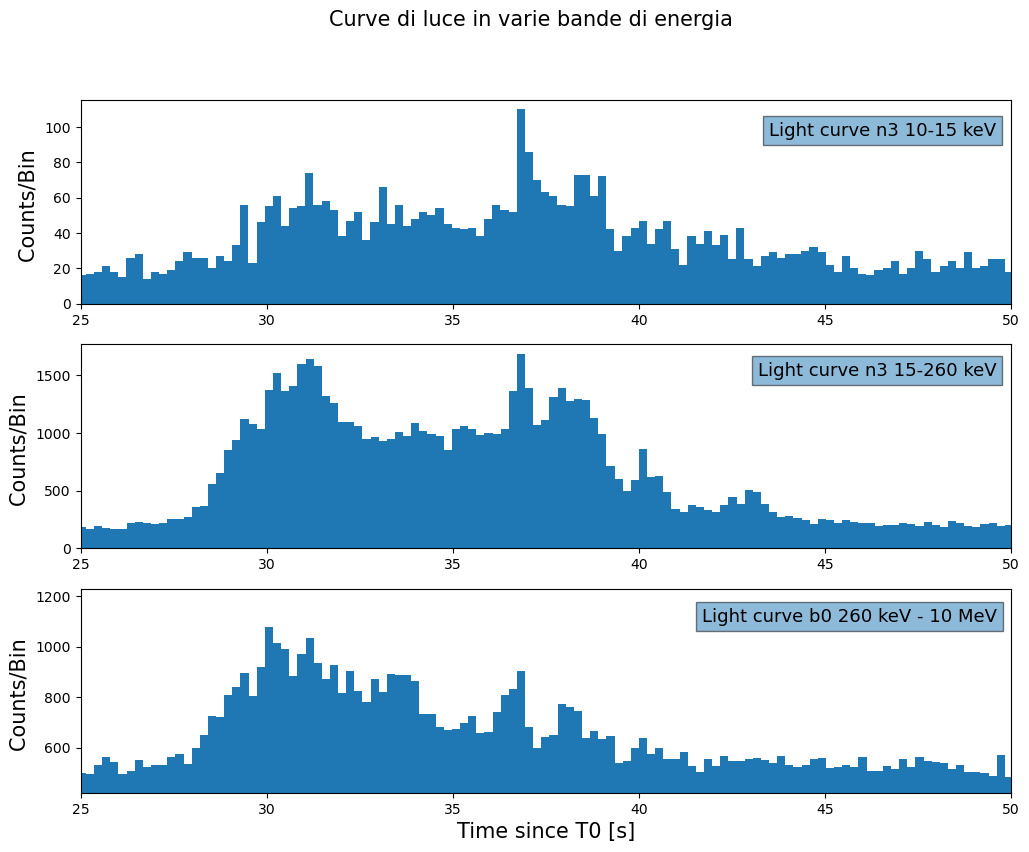

In [20]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 9))
plt.suptitle("Curve di luce in varie bande di energia",fontsize=15)
# Grafico per ax1
ax1.set_ylabel('Counts/Bin ', fontsize=15)
bin_heights, bin_counts, _ = ax1.hist(int_1,bins=1500)
plt.ylim([np.min(bin_heights),np.max(bin_heights)+10])
ax1.text(43.5, 95, 'Light curve n3 10-15 keV', fontsize=13,bbox=dict(alpha=0.5))


# Grafico per ax2
ax2.set_ylabel('Counts/Bin ', fontsize=15)
bin_heights, bin_counts,_=ax2.hist(int_2,bins=1500)
plt.ylim([np.min(bin_heights),np.max(bin_heights)+150])
ax2.text(43.2, 1500, 'Light curve n3 15-260 keV', fontsize=13,bbox=dict(alpha=0.5))

# Grafico per ax3
ax3.set_xlabel('Time since T0 [s]', fontsize=15)
ax3.set_ylabel('Counts/Bin ', fontsize=15)
bin_heights, bin_counts,_=ax3.hist(int_3,bins=1500)


plt.ylim([np.min(bin_heights),np.max(bin_heights)+150])
ax3.text(41.7, 1100, 'Light curve b0 260 keV - 10 MeV', fontsize=13,bbox=dict(alpha=0.5))


# Imposta gli stessi limiti sull'asse x per entrambi i subplot
common_xlim = [25, 50]  # Imposta i limiti dell'asse x desiderati
ax1.set_xlim(common_xlim)
ax2.set_xlim(common_xlim)
ax3.set_xlim(common_xlim)
"""
plot_name = 'Various_bands_light_curves.pdf'
plt.savefig(os.path.join(results_dir, plot_name), bbox_inches='tight')
"""
print("doing my job")